In [2]:
import SimpleITK as sitk
import os
import numpy as np
from tqdm import tqdm

In [3]:
def read_image(path: str):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(path)

    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    return sitk.GetArrayFromImage(itkimage)

In [4]:
img_files = list(os.scandir(r'C:\Users\Roel\Documents\scan_cropped4'))

In [5]:
img = read_image(img_files[0].path)

In [6]:
def get_slabs(img: np.ndarray, axis: int, n_slabs: int, slab_size, agg_func=np.mean):
    size = img.shape[axis]
    if isinstance(slab_size, float):
        slab_size = int(slab_size * size)
    full_slices = [slice(img.shape[d]) for d in range(3)]
    slabs = []
    for i in range(n_slabs):
        slab_pos = int(size*0.75/(n_slabs-1)*i+0.125*size)
        slab_start = np.clip(slab_pos - slab_size//2, 0, size)
        slab_end = np.clip(slab_pos + slab_size//2, 0, size)
        slices = full_slices.copy()
        slices[axis] = slice(int(slab_start), int(slab_end)+1)
        if agg_func != np.average:
            slab = agg_func(img[tuple(slices)], axis=axis)
        else:
            kernel = np.zeros((int(slab_end - slab_start + 1), ))
            kernel[int(slab_pos-slab_start)] = 1
#             if i == 10:
#                 print(slab_size, slab_start, slab_end)
#                 plt.plot(kernel)
#                 plt.show()
            kernel = gaussian_filter1d(kernel, sigma=2.8)
#             if i == 10:
#                 plt.plot(kernel)
#                 plt.show()
            slab = agg_func(img[tuple(slices)], axis=axis, weights=kernel)
        slabs.append(slab)
    return slabs

In [7]:
import matplotlib.pyplot as plt
def plot_slabs(slabs):
    for slab in slabs:
        plt.imshow(slab)
        plt.show()

In [8]:
from scipy.ndimage import gaussian_filter1d

In [9]:
slabs = get_slabs(img, 0, 30, 1/28, agg_func=np.mean)

In [21]:
img.dtype

dtype('int16')

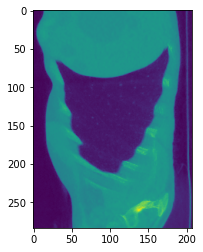

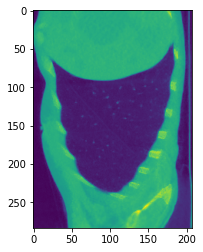

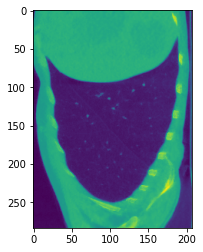

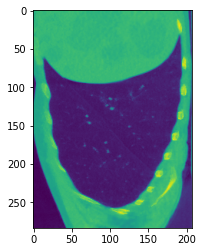

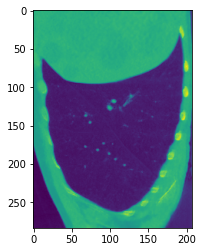

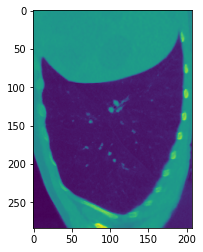

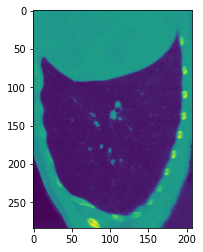

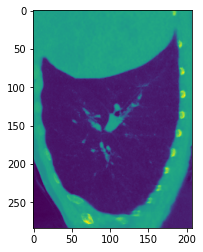

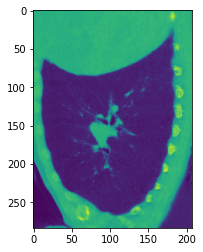

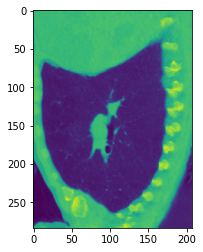

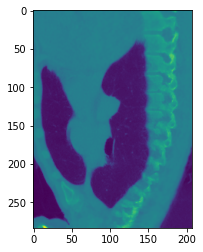

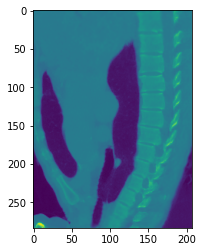

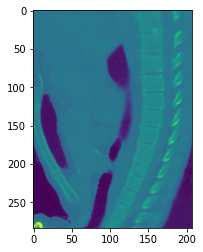

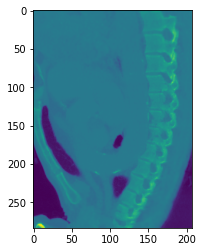

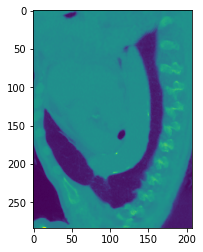

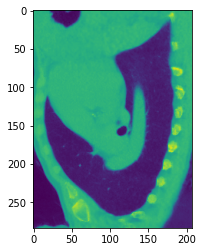

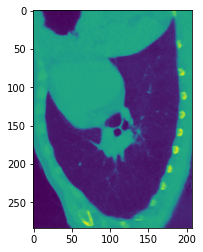

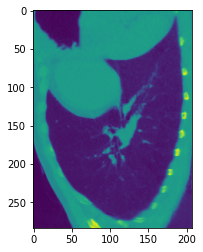

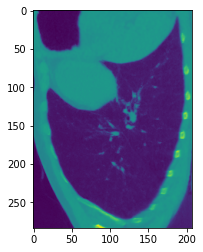

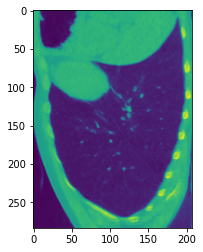

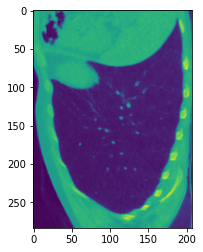

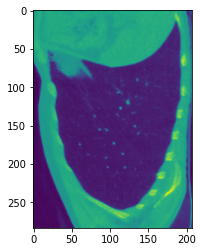

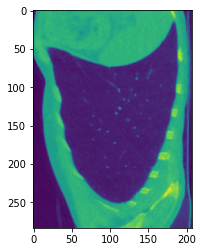

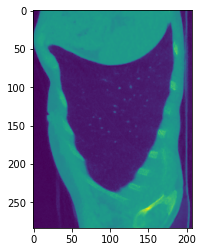

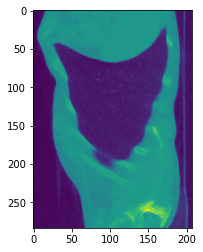

In [11]:
plot_slabs(get_slabs(img, 2, 25, 1/24, agg_func=np.median))

In [26]:
agg_funcs = [np.mean, np.median, np.max, np.average]
axes = [0, 1, 2]

In [27]:
from tifffile import imwrite

In [28]:
!mkdir slab_images

A subdirectory or file slab_images already exists.


In [29]:
def normalize(img):
    normed = (img - img.min()) / (img.max() - img.min()) * 255
    return np.stack([normed]*3, axis=2).astype(np.uint8)

In [30]:
for img_file in tqdm(img_files):
    img = read_image(img_file.path)
    for axis in axes:
        for agg_func in agg_funcs:
            if agg_func != np.average:
                slabs = get_slabs(img, axis, 25, 1/24, agg_func=agg_func)
            else:
                slabs = get_slabs(img, axis, 25, 1/20, agg_func=agg_func)
            for i, slab in enumerate(slabs):
                imwrite(f'slab_images/{os.path.splitext(img_file.name)[0]}_{axis}_{agg_func.__name__}_{i}.tif', normalize(slab))

 91%|█████████████████████████████████████████████████████████████████████████████████████▌        | 918/1009 [37:17<03:59,  2.63s/it]c:\users\roel\.virtualenvs\diagcovid-ckc2berq\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in short_scalars
  
100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1009/1009 [40:59<00:00,  2.44s/it]


In [94]:
os.path.splitext(img_files[0].name)[0]

'10351_st000'

In [106]:
agg_funcs[2].__name__

'amax'

In [20]:
import tifffile

In [ ]:
tifffile.TiffWriter()